# Pulsar Timing Array Supermassive Black Hole Binaries to Gravitational Wave Background
-----

Here we create a Skymap through a series of user inputs, resulting in a gif that calculates the gravitational waves strain and the time of arrival perturbation of pulsar pulses.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import healpy as hp
import gw_sky_utils as gw_utils
from gw_sky import gwsky
%config InlineBackend.figure_format = 'retina'

User prompt for which type of Skymap you'd like to generate.

1. Skymap
2. Skymap + SMBHB PSD 

In [20]:
map_type = int(input('Input integer associated with option:'))

if map_type == 1:
    print('Skymap')
    map_type = 'sky-map'
else:
    print('Skmap + PSD')
    map_type = 'sky-map-psd'

Skmap + PSD


User prompt for how many maximum sources you'd like (Recommended: 250)

On slower machines increased source number (>500) risks kernal failure.

In [21]:
pop = gwsky.smbbh_pop()
smbhb_count = int(input('Maximum number of sources:'))
print(smbhb_count,'sources')
if smbhb_count > pop['Strain'].size:
    error_mes = "Reqeusted source amount is greater than amount in catalogue"
    raise error_mes

20 sources


User prompt to enable location markers for every SMBHB on the Skymap.
Input: Yes or No. As sources increase the markers will take up more space, I'd suggest leaving them off for a source count > 250

In [22]:
marker_value = input("on or off")

if marker_value.lower() == 'on':
    print('Markers On')
    marker_value = True
else:
    print('Markers Off')
    marker_value = False

Markers Off


User prompt to specify a preferred SMBHB characteristic strain in the Skymap. Below shows the different options at your disposal. Just as before, input the associated integer into the prompt.

1. Random sample of all sources.
2. Loudest sources only

In [23]:
import gw_sky_utils as gw_utils
freq_pref = int(input('Input integer associated with option:'))
pair_index = gw_utils.smbhb_freq_range(freq_pref, smbhb_count)

Random Sample


The following block generates random sky positions for the SMBHB and uses strain & frequency values out of catalogue to be used in the Skymap & PSD.

In [6]:
# Generates random sky positions for SMBHB. 
L = smbhb_count
costh = np.random.uniform(-1,1,size= L-3)
th = np.arccos(costh)
ph = np.random.uniform(0,2*np.pi,size= L-3)
th = np.append([np.pi/2,np.pi/4,np.pi/2+0.1],th)
ph = np.append([0,3*np.pi/2,np.pi-0.1],ph)
gw = []

if map_type == 'sky-map-psd': # Creates separate numpy arrays for PSD generation.
    source_freq = np.zeros(L)
    source_strain = np.zeros(L)

for i in range(L):
    freq = pop['GWFreq'][pair_index[i]]
    h = -pop['Strain'][pair_index[i]] # Strains are saved as negative values for some reason...
    gw.append(gwsky.SMBBH(freq,h,th[i],ph[i]))

    if map_type == 'sky-map-psd':
        source_freq[i] = freq # Contains frequencies of sources: used for SMBBH figure
        source_strain[i] = h # contains Strain of sources: used for SMBBH figure
        
        
if map_type == 'sky-map-psd':
    
    arg_sort = source_freq.argsort()
    source_strain[arg_sort]
    
    

In [7]:
t = np.linspace(0,12.9*365.25*24*3600,200)
yr_in_sec = 365.25*24*3600
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta, phi = hp.pix2ang(nside=NSIDE,ipix=IPIX)
sky = gwsky.GWSky(gw,theta,phi)

Here you have the option of changing what the Skymap will visualize; Timing residuals or Characteristic Strain. (Default is set to residuals)

In [8]:
# str = sky.strain(t)
res = sky.residuals(t)
res.shape

(12288, 20, 200)

## Skymap Generation

Here we start generating the healpy skymaps from the inputs above, with samples of what the Skymap will look like.

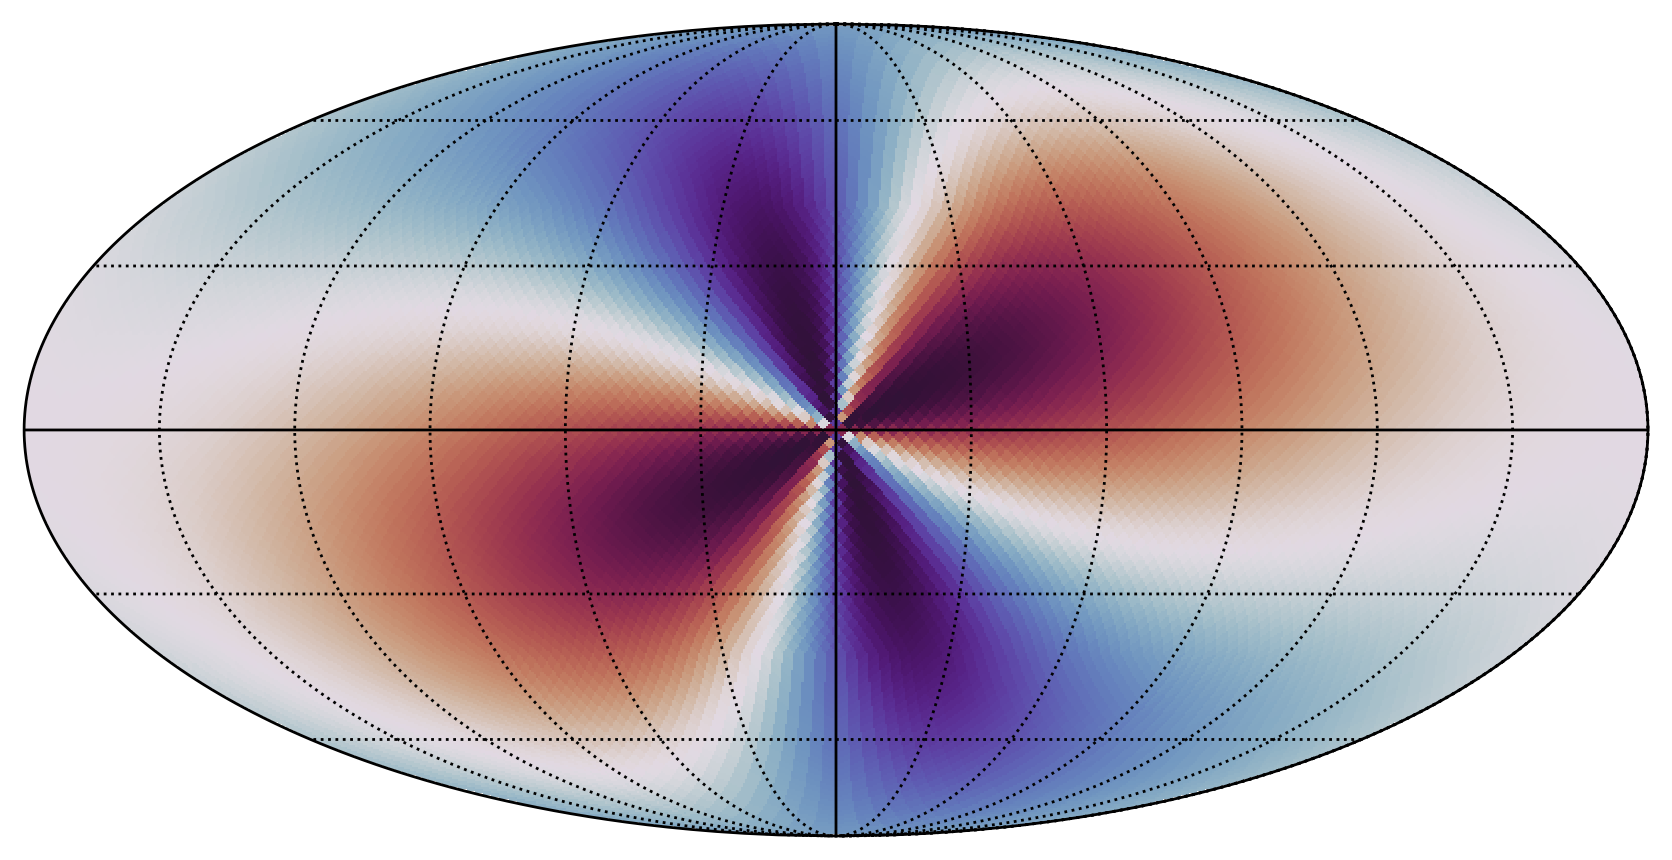

In [9]:
hp.mollview(res[:,0,0], cbar=False,title='',cmap='twilight_shifted_r')
hp.graticule(verbose=False)

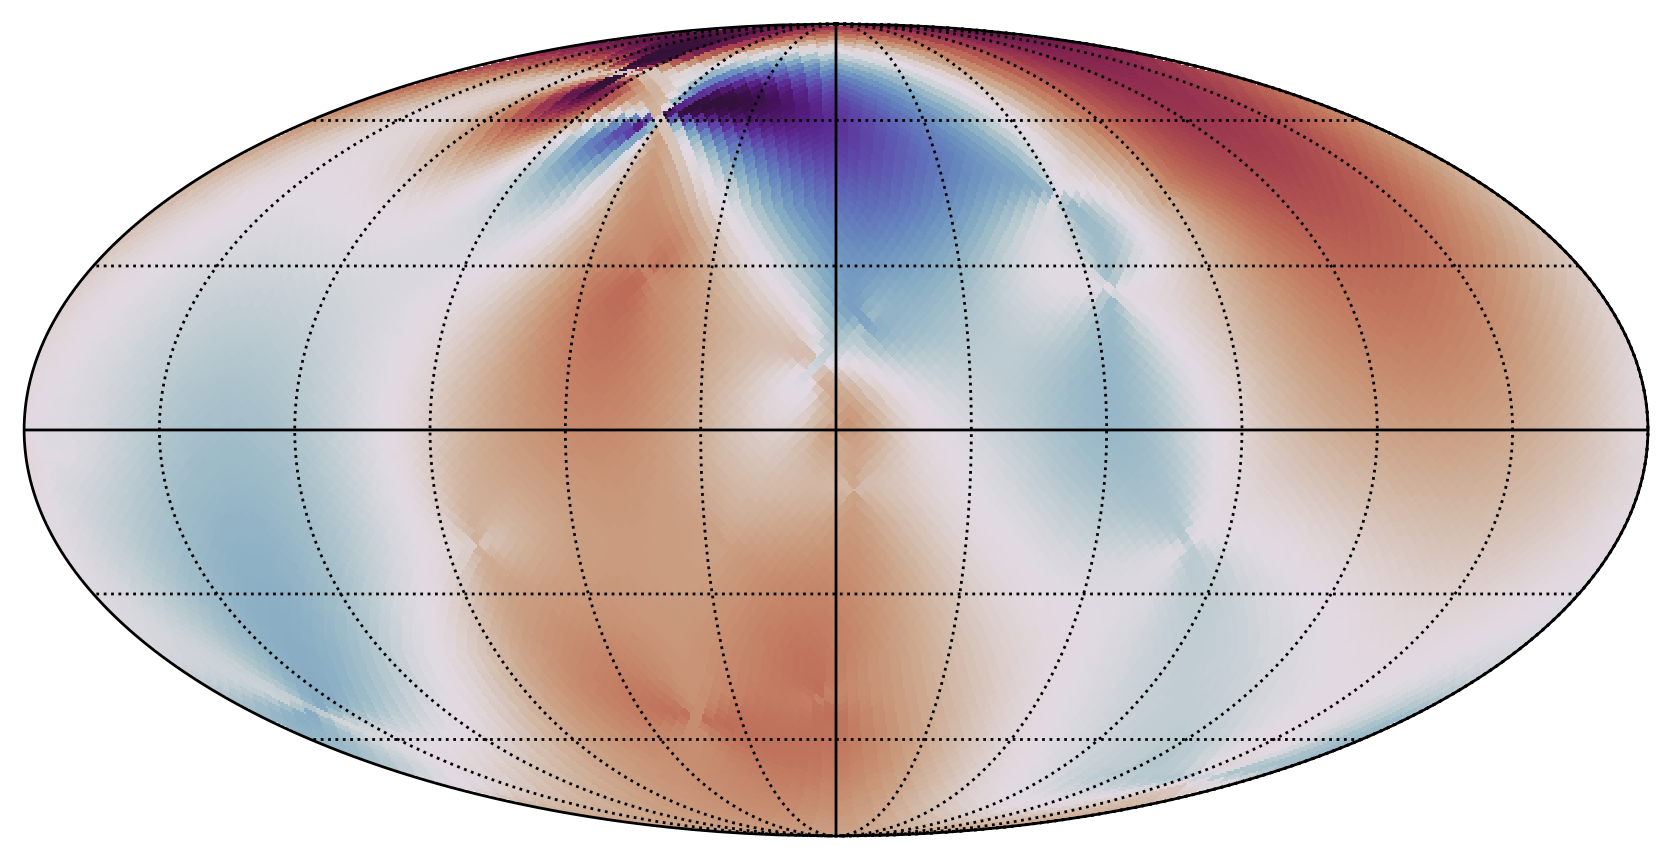

In [10]:
hp.mollview(np.sum(res[:,:,0],axis=1), cbar=False,title='',cmap='twilight_shifted_r')
hp.graticule(verbose=False)

##### Convenience functions for plotting.

In [11]:
def maxmin(array):
    """Return the max an min of an array."""
    return array.max(), array.min()

def gw_sum(array, n='all'):
    '''
    Convenience function to return either a single source,
    sum of a list of sources indicated by index or all summed sources.
    '''
    if n=='all':
        return np.sum(array,axis=1)
    elif isinstance(n,list):
        return np.sum(array[:,n,:],axis=1)
    elif isinstance(n,int):
        return array[:,n,:]

##### The following block contains the plotting components of the Skymap that use Matplotlib to plot Pulsar locations & SMBHB markers if enabled.

In [12]:
def plot_gw(residuals, save_path ,psrs=[0,1,[0,1],'all'],Nt=1,action='show', name='./gwb_resids/gwb_full'):
    ii = 0
    
    for p in psrs:
        res = gw_sum(residuals,n=p)
        Max, Min = maxmin(res)
        idx1 = 9000
        idx2 = 6500
        idx3 = 2500
        ang1=hp.pix2ang(NSIDE,idx1)
        ang2=hp.pix2ang(NSIDE,idx2)
        ang3=hp.pix2ang(NSIDE,idx3)
        
        if p=='all':
            space = 0.01*2*(res[idx1,:].max()+res[idx2,:].max()+res[idx3,:].max())

        else:
            space = 0.1*2*(res[idx1,:].max()+res[idx2,:].max()+res[idx3,:].max())
        shifts = [np.abs(res[idx1,:].min())+ res[idx2,:].max() + space,
                  0,
                  res[idx2,:].min() - res[idx3,:].max() - space]


        if isinstance(p,int):
            N = 1
            
        elif isinstance(p,list):
            N = len(p)
                
        elif p=='all':
            
            N = L
        
        for n in range(Nt):
            
            if map_type == 'sky-map-psd':
            
                gs = gridspec.GridSpec(2,2, wspace=0.2, hspace=0.5, width_ratios=[3,2], height_ratios=[3,2])

                fig = plt.figure(figsize=(18,15)) # Creates main figure.            
                ax1 = plt.subplot(gs[0, :]) # Skymap: Column 1, Span all rows.
                ax1 = plt.subplot(gs[0, :])
                ax2 = plt.subplot(gs[1, 0]) # Strain map, column 1, row 0,
                ax3 = plt.subplot(gs[1, 1]) # Source map. Column 2, row 0.
                
                ax3.set_xscale("log") # SMBHH figure to log log scale.
                ax3.set_yscale("log")
                ax3.set_xlim([10**-9, 10**-7])
                year_s = 3.15*10**7
                ax3.axvline(x =1/year_s , color = 'darkorange', label = '1/year', alpha = 0.6, linewidth = 2, linestyle='dashed')
                gw_utils.plot_points(source_strain, source_freq, ax3, p, L)


                # Plot the verticle line that shows the current time.
                ax2.set_yticks([])
                ax2.set_xlabel('Years',fontsize=12)
                ax2.set_ylabel(r'Gravitational Wave Strain',fontsize=12)
                ax2.set_title('Timing Residuals')
                ax2.grid(alpha = 0.5) # Alpha for Pulsar grid

                ax3.grid(alpha = 0.5) # Alpha for SMBBH grid. 
                ax3.set_xlabel("Frequency [hz]")            
                ax3.set_ylabel("Strain [h]")
                ax3.set_title('SMBHB Population & PSD')

                box = ax3.get_position()
                box.y0 = box.y0 + 0.051
                box.y1 = box.y1 + 0.045
                ax3.set_position(box)

                fig.text(x=0.823,y=0.145, s = '1/yr', fontsize = 9)
                fig.text(x=0.64,y=0.90,s='Image Credit: Jeffrey S. Hazboun, Peter J. Orndoff', fontsize = 14)
                fig.text(x=0.45,y=0.47, s ="Number of SMBHB: {0}".format(N), fontsize = 14)

                box = ax2.get_position()
                box.y0 = box.y0 + 0.051
                box.y1 = box.y1 + 0.051
                ax2.set_position(box)
    
            else:
            
                fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[9,9],gridspec_kw={'height_ratios': [2, 1]})            
                ax2.set_title('Number of Gravitational Waves Sources: {0}'.format(N))
                fig.text(x=0.57,y=0.87,s='Image Credit: Jeffrey S. Hazboun, Peter J. Orndoff', fontsize = 9)
                
                
            plt.sca(ax1)
            hp.mollview(res[:,n], cbar=False,title='',cmap='twilight_shifted_r',min=Min,max=Max, hold=True)
            hp.graticule(verbose=False)
            ax2.axvline(t[n]/yr_in_sec, linewidth=0.7,color='k')
            
            # Plot the stars on the sky map
            hp.projscatter(ang1[0],ang1[1],s=22**2,marker='*',color='C0',edgecolors='k',zorder=3)
            hp.projscatter(ang2[0],ang2[1],s=22**2,marker='*',color='C1',edgecolors='k',zorder=3)
            hp.projscatter(ang3[0],ang3[1],s=22**2,marker='*',color='C3',edgecolors='k',zorder=3)
    
            # Plot the traces on the traceplot. Shift by the amount calculated above.
            ax2.plot(t/yr_in_sec,res[idx1,:]+shifts[0],color='C0', lw=2)
            ax2.plot(t/yr_in_sec,res[idx2,:]+shifts[1],color='C1', lw=2)
            ax2.plot(t/yr_in_sec,res[idx3,:]+shifts[2],color='C3', lw=2)
            
            # Plot the stars on the trace plot
            ax2.scatter(0,res[idx1,0]+shifts[0],s=22**2,marker='*',color='C0',edgecolors='k',zorder=3)
            ax2.scatter(0,res[idx2,0]+shifts[1],s=22**2,marker='*',color='C1',edgecolors='k',zorder=3)
            ax2.scatter(0,res[idx3,0]+shifts[2],s=22**2,marker='*',color='C3',edgecolors='k',zorder=3)
            
            # Plot the verticle line that shows the current time.
            ax2.axvline(t[n]/yr_in_sec, linewidth=0.7,color='k')
            ax2.set_yticks([])
            ax2.set_xlabel('Time [yr]',fontsize=12)
            ax2.set_ylabel(r'Strain [h]',fontsize=12)

            if marker_value is True:

                if isinstance(p,int):
                    hp.projscatter(th[p],ph[p],s=8**2,marker='o',color='black',edgecolors='white',zorder=3)

                    
                elif isinstance(p,list):
                    
                    hp.projscatter(th[p],ph[p],s=8**2,marker='o',color='black',edgecolors='white',zorder=3)

                elif p=='all':
                    hp.projscatter(th[:N],ph[:N],s=8**2,marker='o',color='black',edgecolors='white',zorder=3)
                
            
            if action=='save':
                plt.savefig(save_path+'/{0}_{1}.png'.format(name,ii), dpi=171, bbox_inches='tight')
            elif action=='show':
                plt.show()
            
            ii+=1
                    
            plt.close()

## Making Animations
The following block requires the package `ffmpeg` which can be installed via conda or your favorite package manager for `c` code. 

The block calls the functions `giffify` from `gw_utils` which creates a a new folder in the directory the script is located. The folder will contain an image, pallete, and gif folder respectively that contains the generated content for the gif creation.


The 'ffmpeg' package creates a `gif` out of a series of Matplotlib frames which is then saved in the `gif` folder.

User prompt to specify how many sources per iteration you would like the gif to have

For example: If you wanted to visualize 7 iterations that use 1, 5, 10, 50, 100, 200, 500 number of sources per iteration to visualize you would enter the following:
1. How many iterations? 7
2. Enter Iteration order separated by a comma: Input: 1, 5, 10, 50, 100, 200, 500

In [13]:
source_iterations = input('How many iterations?:')
source_iteration_order = input('Itations order separated by a comma:')
print('Iterations: '+source_iterations, '\nIteration Order: '+source_iteration_order )

Iterations: 3 
Iteration Order: 1,5,20


In [14]:
psrs = gw_utils.source_creator(source_iterations, source_iteration_order)

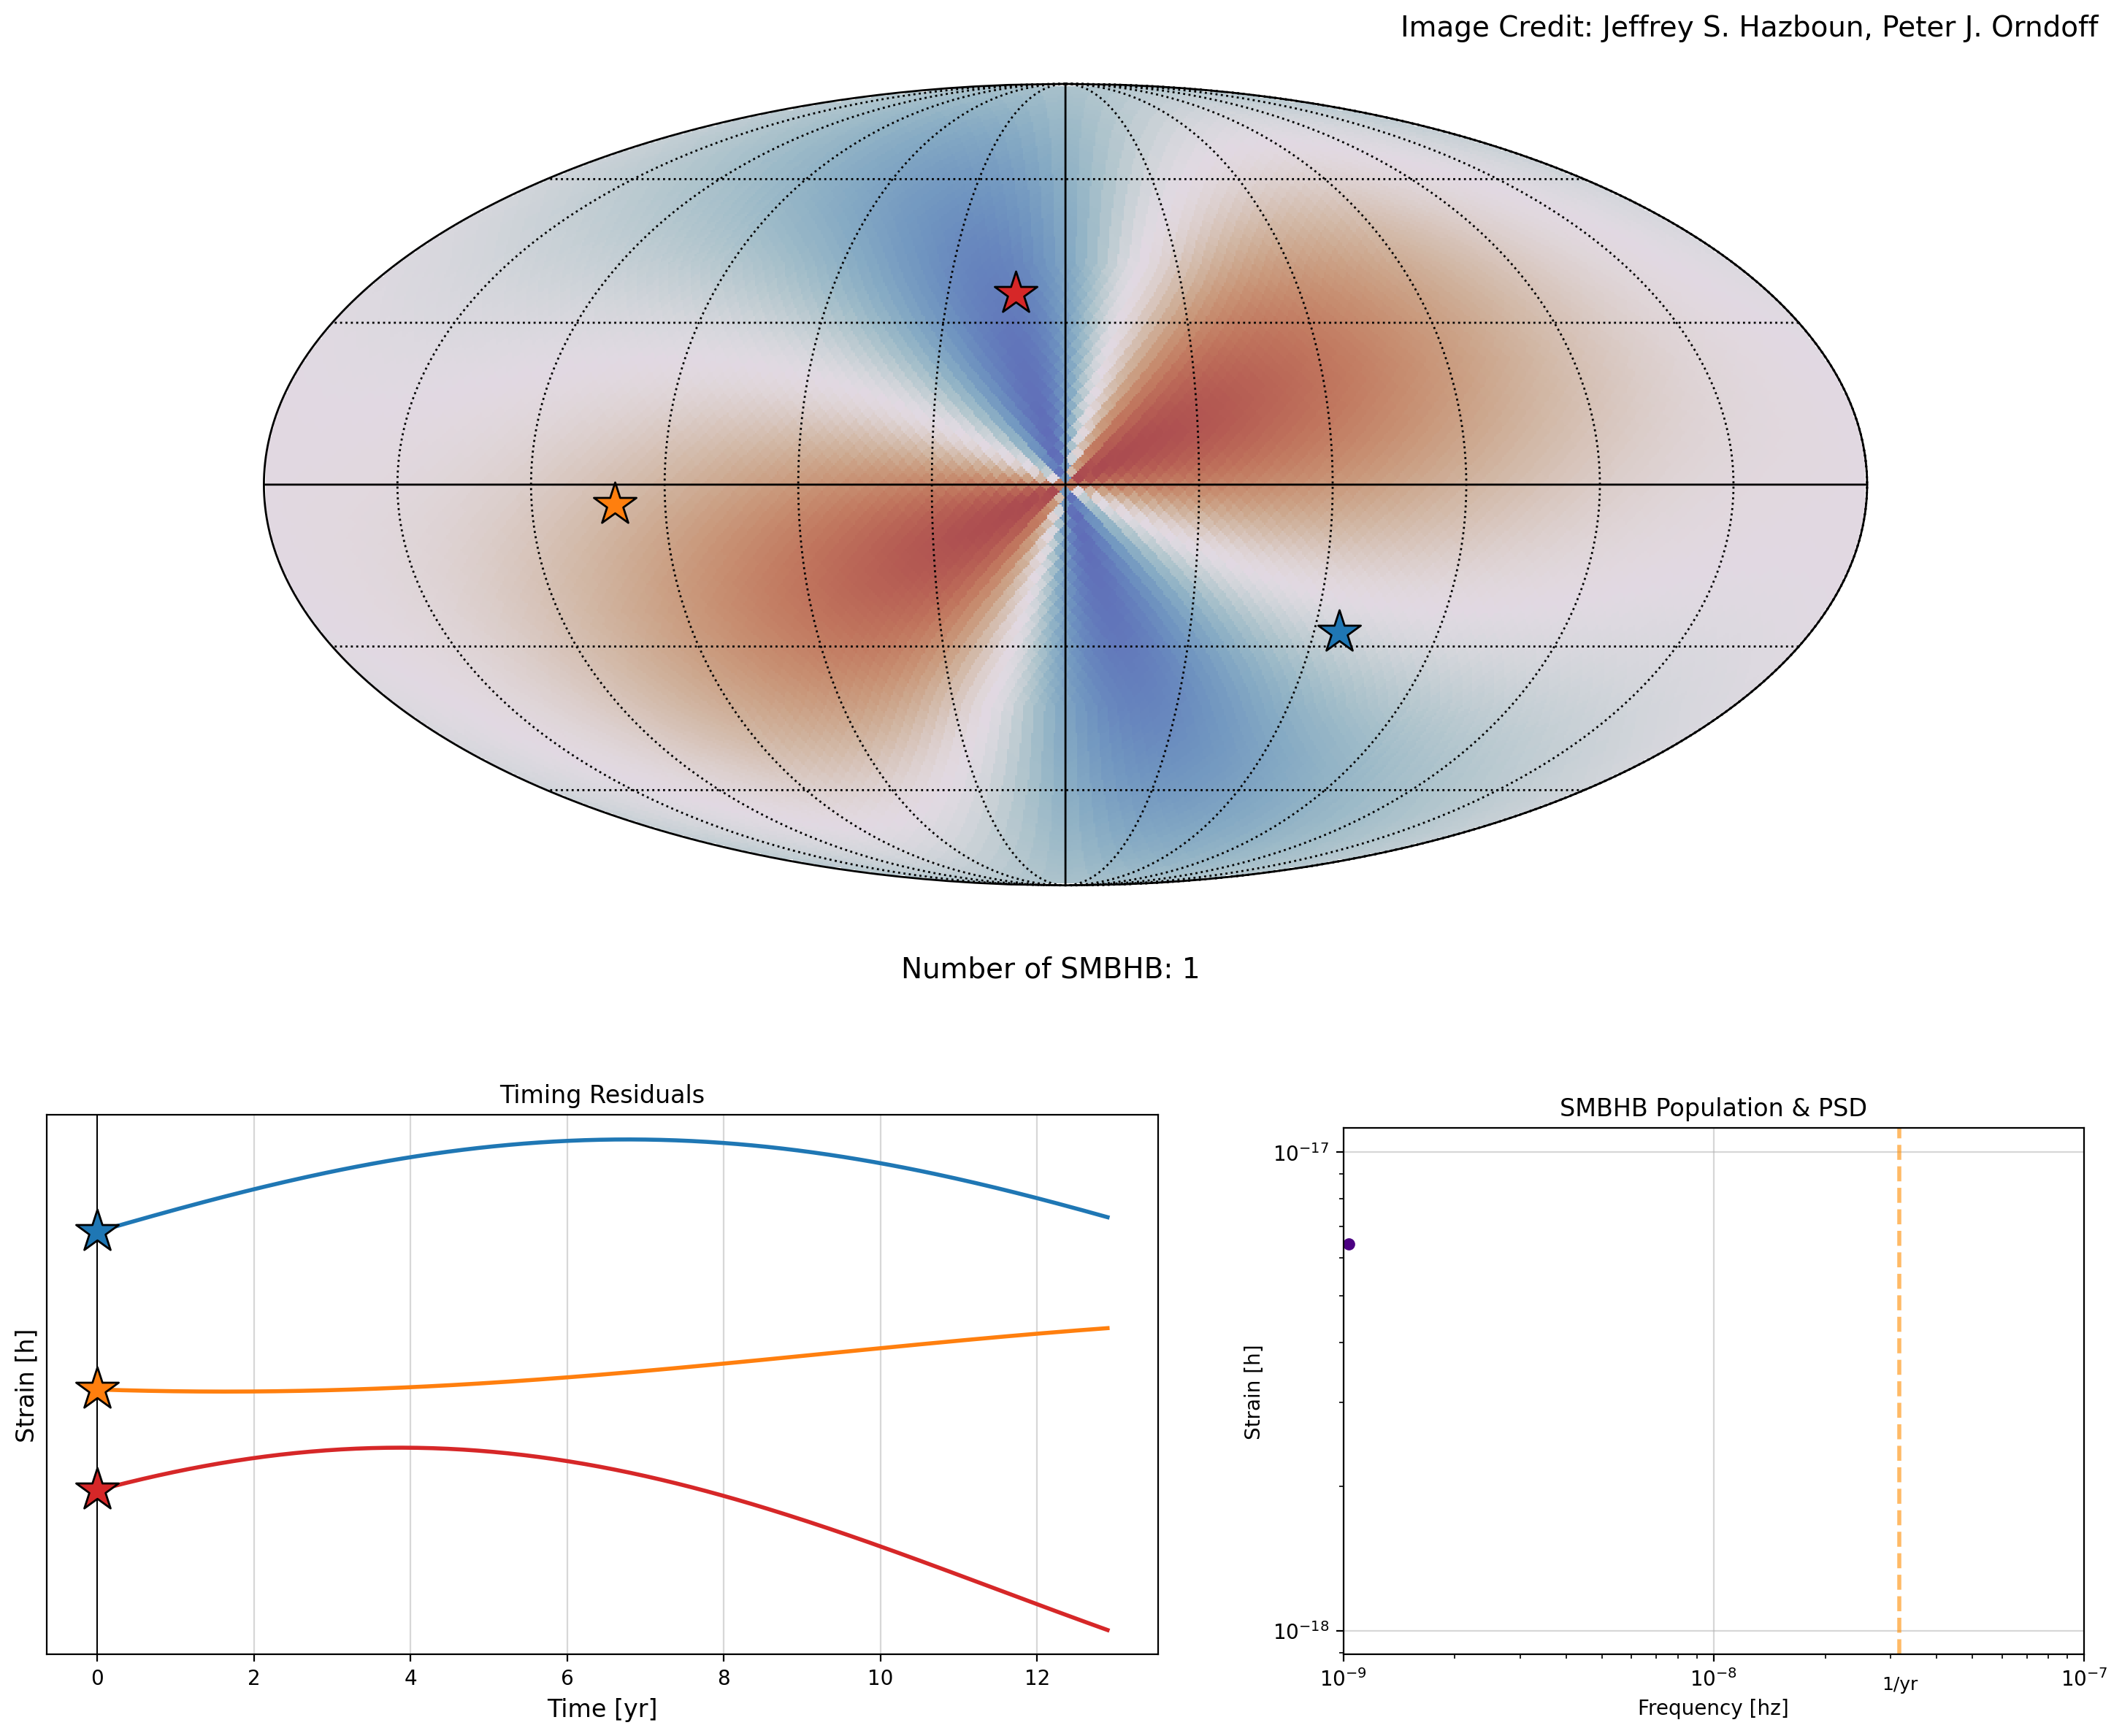

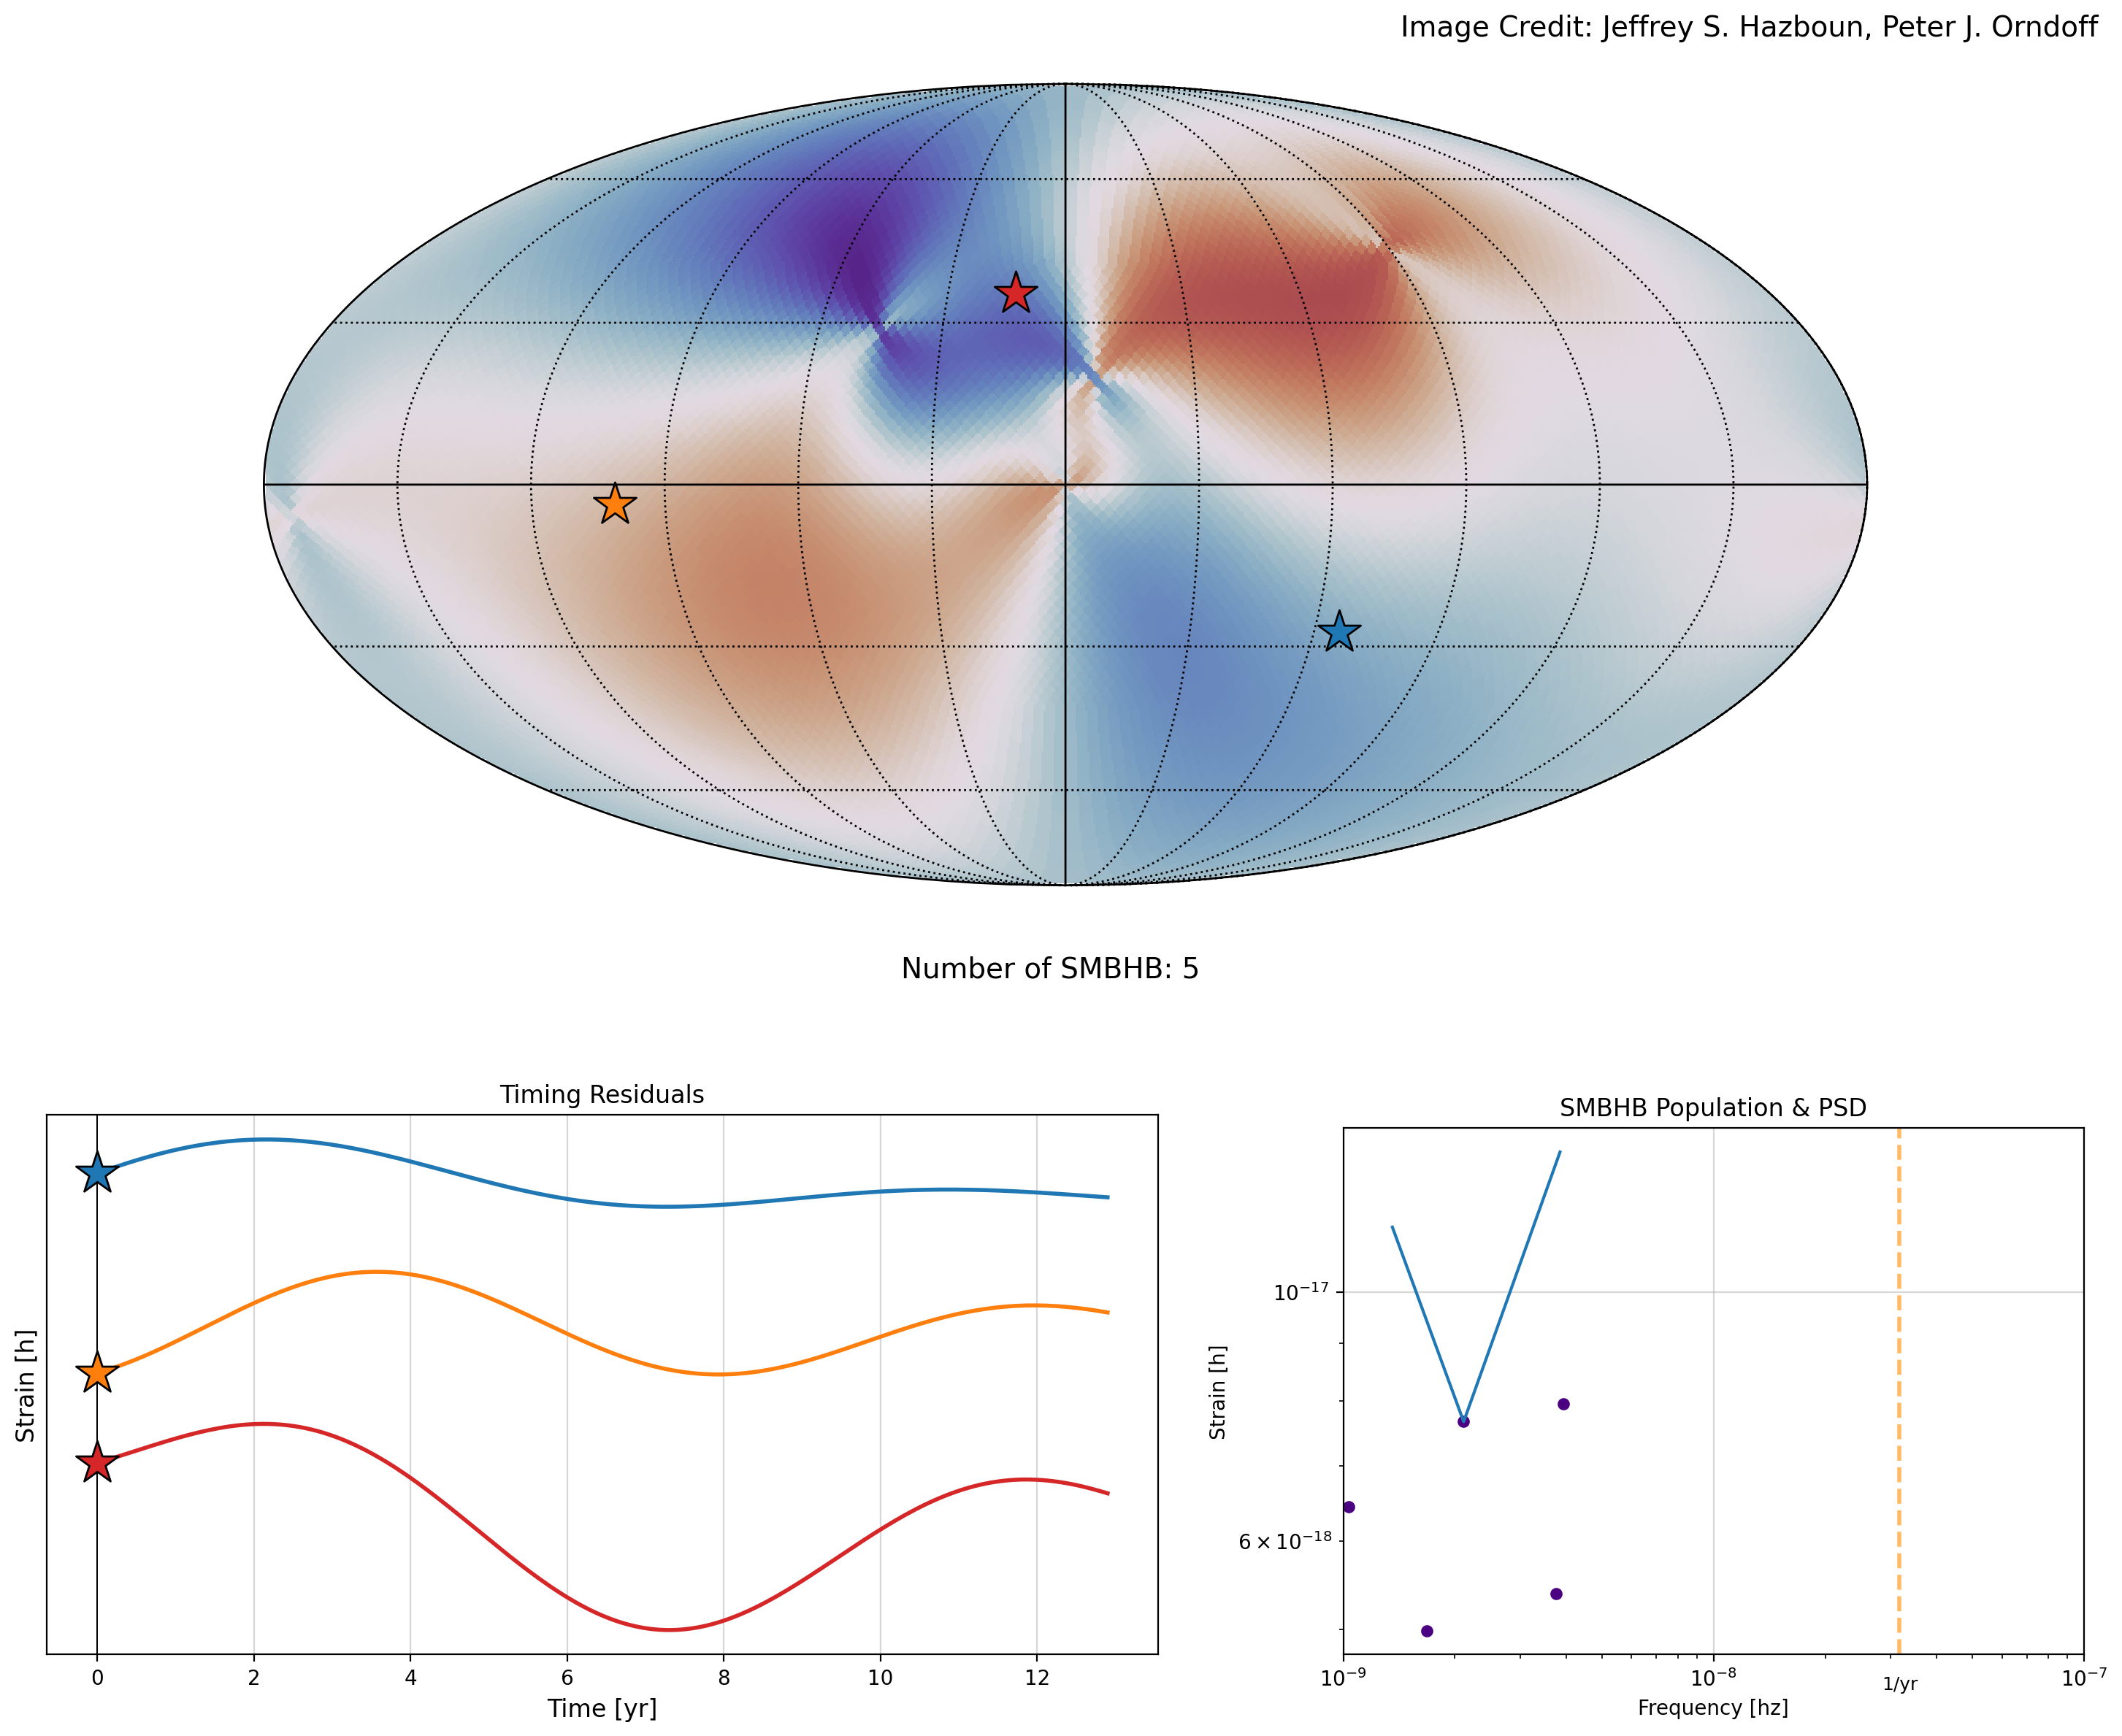

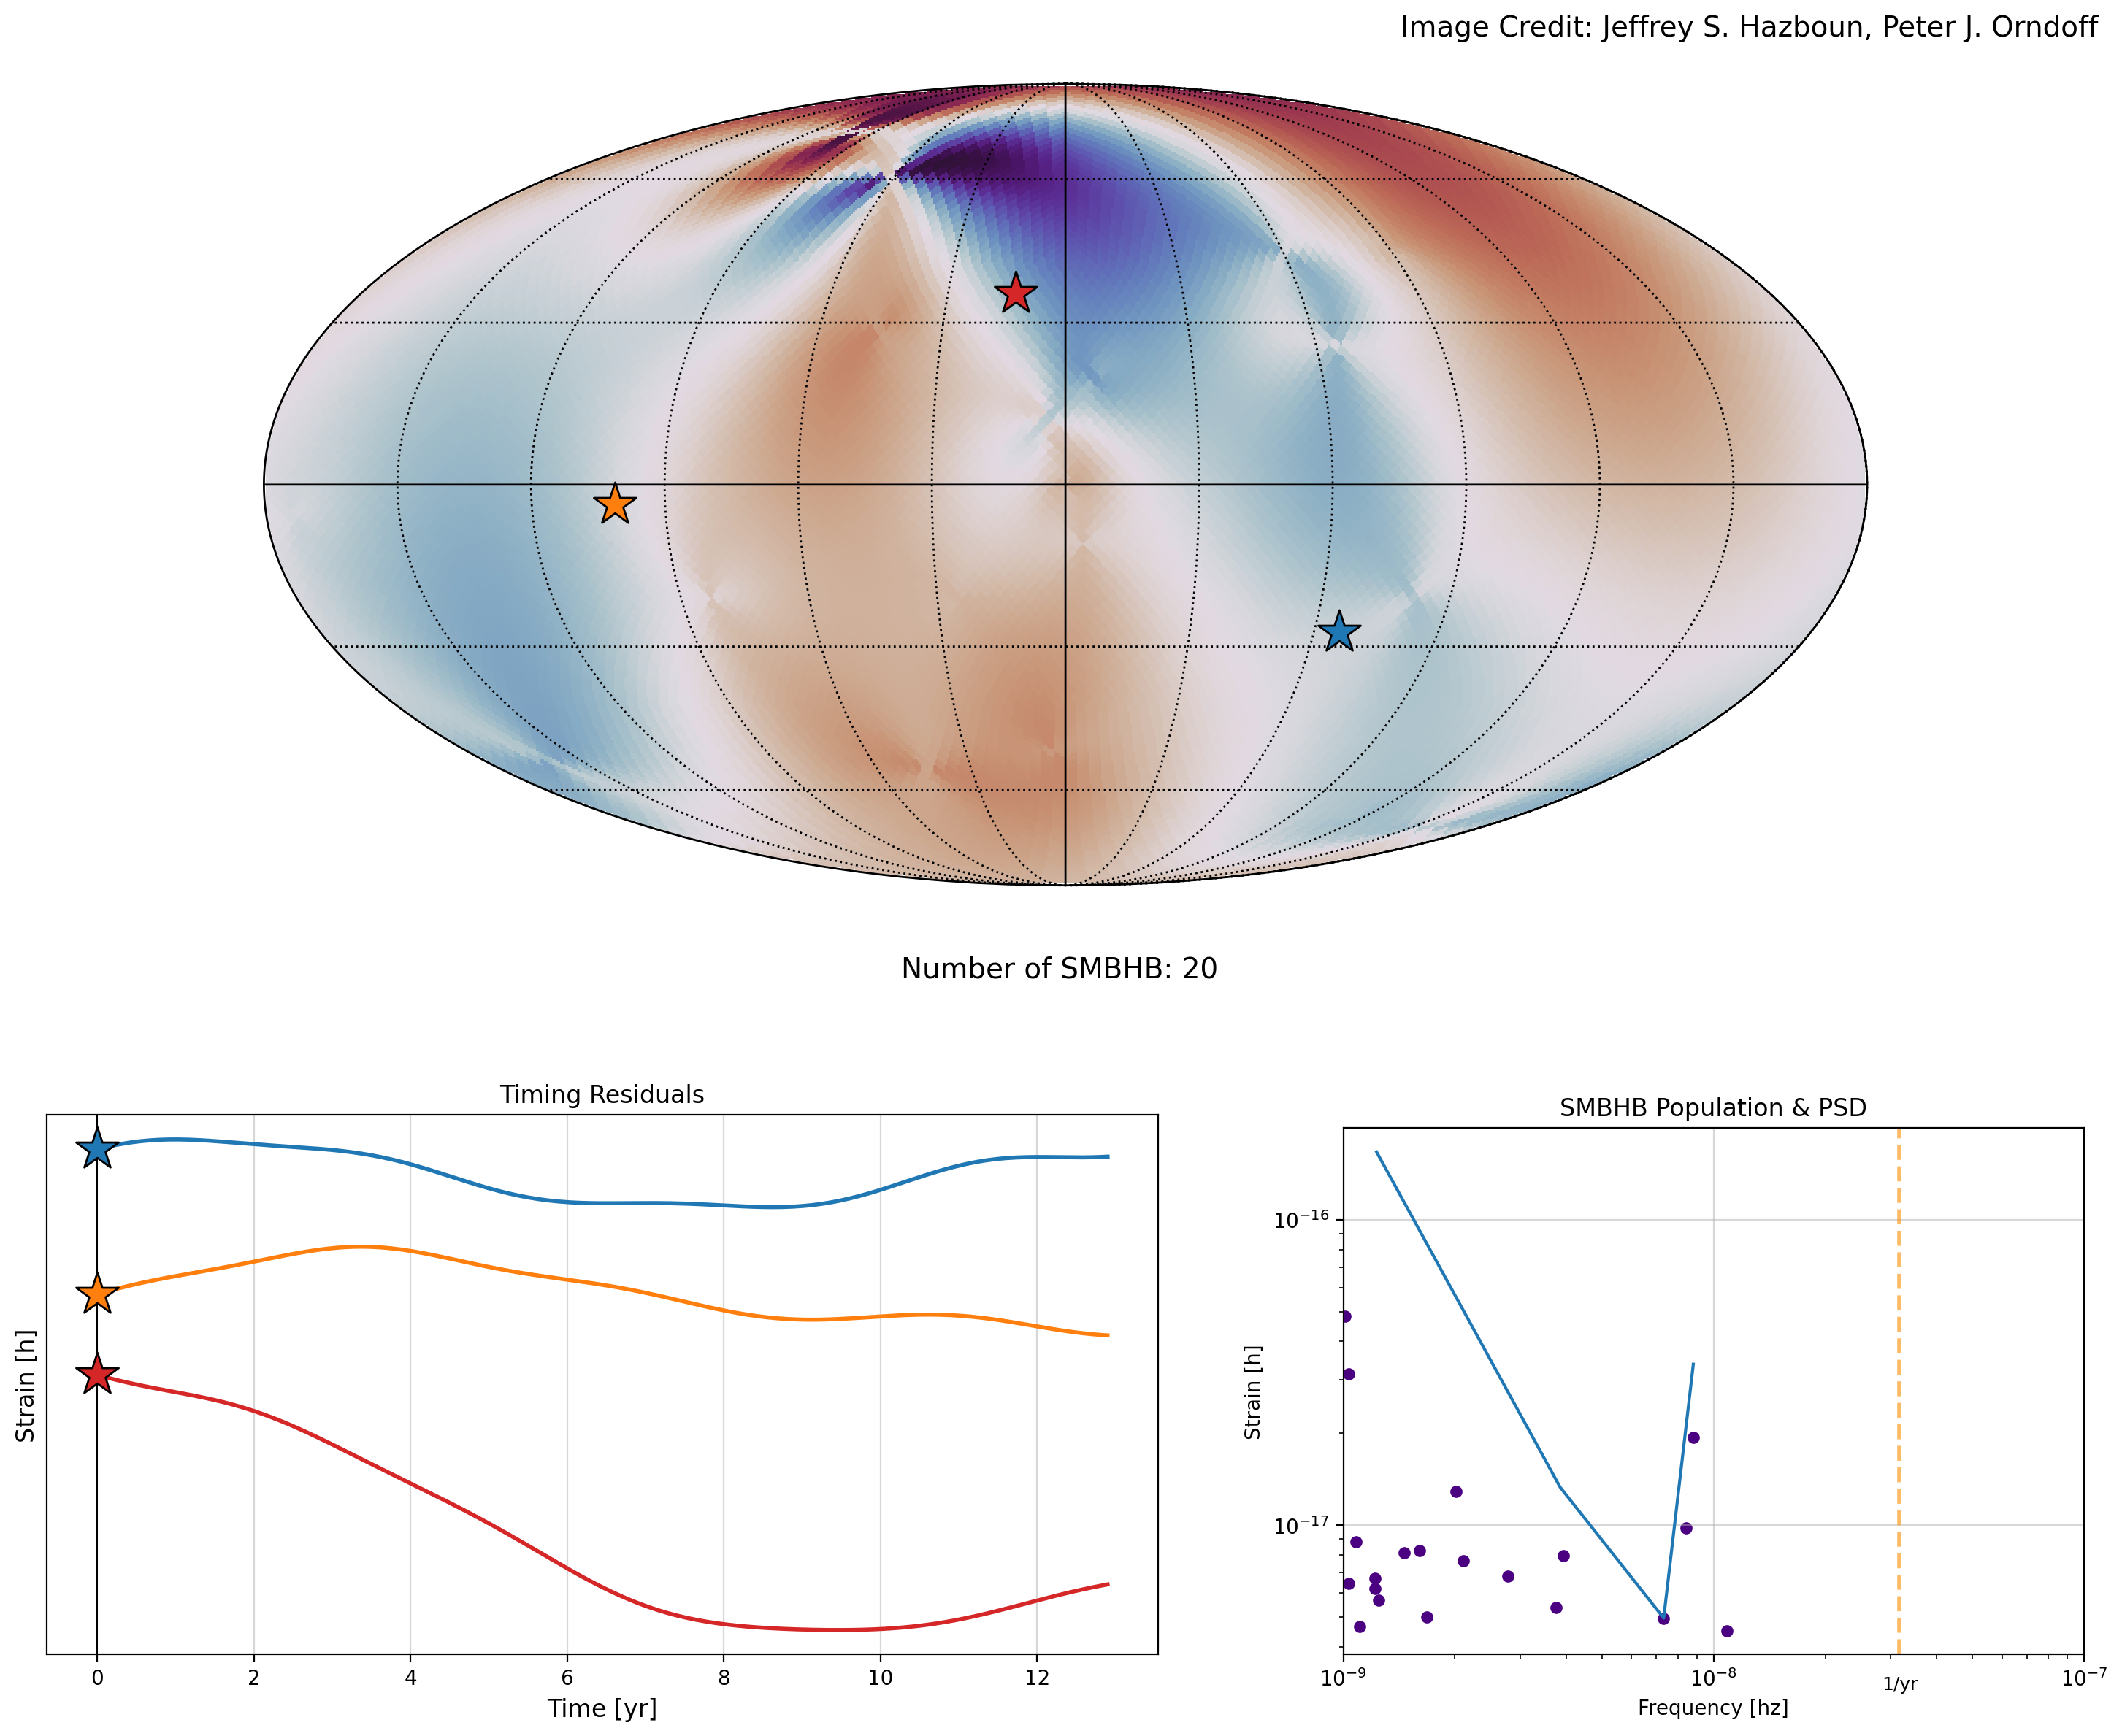

In [15]:
plot_gw(res,'/', psrs, Nt=1, action='show')

In [16]:
user_in = input('Proceed with gif creation?')
if user_in.lower() == 'yes':

    paths_dict = gw_utils.path_creation()
    print('Creating Images...this may take awhile') 
    plot_gw(res, paths_dict['images'], psrs, Nt=200, action='save', name='swg_png')
    print('All images created, proceeding to gif creation..')
    gw_utils.giffify(f"{paths_dict['images']}/swg_png_%d.png", f"{paths_dict['gifs']}/{paths_dict['folder_name']}.gif", f"{paths_dict['pallette']}/palette.png")
    print('Gif creation completed and it located here: ', paths_dict['gifs'])
